In [3]:
ticker = "NVDA"
# df = pd.read_csv(f'/content/{ticker}_articles_10052025_11032025.csv')
df = pd.read_csv("/content/NVDA_articles_07102021_10052025.csv")

In [4]:
len(df)

19285

In [2]:
import pandas as pd
import numpy as np

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from collections import defaultdict
from sentence_transformers import SentenceTransformer

In [6]:
# --------------------------------------------
# 1. Create full text column
# --------------------------------------------

df["full_text"] = df["title"].fillna('') + ". " + df["text"].fillna('')

In [ ]:
# # --------------------------------------------
# # 2. Load Sentence Transformer model
# # --------------------------------------------

# from tqdm import tqdm
# from transformers import AutoTokenizer, AutoModel
# import torch
# import numpy as np

# tokenizer = AutoTokenizer.from_pretrained('valurank/MiniLM-L6-Keyword-Extraction')
# model = AutoModel.from_pretrained('valurank/MiniLM-L6-Keyword-Extraction')

# def get_embedding(text):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#         last_hidden = outputs.last_hidden_state  # [1, seq_len, hidden]
#         sentence_embedding = last_hidden.mean(dim=1).squeeze().numpy()  # mean pooling
#     return sentence_embedding

# # # Example usage
# # text = "NVIDIA stock surges after strong Q3 earnings."
# # embedding = get_embedding(text)
# # print(embedding)  # should be (384,)

# # Generate embeddings for each article
# # Apply to full_text column

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def get_embedding_and_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        # Softmax over sentiment logits
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().cpu().numpy()
        label_index = int(probs.argmax())
        label = model.config.id2label[label_index]
        score = probs[label_index]
        # Mean pooling over token embeddings
        embedding = outputs.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()
    return embedding, label, float(score)

from tqdm import tqdm

embeddings = []
sentiment_labels = []
sentiment_scores = []

for text in tqdm(df["full_text"].tolist()):
    emb, label, score = get_embedding_and_sentiment(text, model, tokenizer)
    embeddings.append(emb)
    sentiment_labels.append(label)
    sentiment_scores.append(score)

# Add to dataframe
df["embedding_finbert"] = embeddings
df["sentiment_label_finbert"] = sentiment_labels
df["sentiment_score_finbert"] = sentiment_scores

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

  0%|          | 1/19285 [00:00<1:34:39,  3.40it/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

100%|██████████| 19285/19285 [56:17<00:00,  5.71it/s]


In [ ]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
# model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# def get_embedding_and_sentiment(text, model, tokenizer):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
#     with torch.no_grad():
#         outputs = model(**inputs, output_hidden_states=True)
#         # Softmax over sentiment logits
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().cpu().numpy()
#         label_index = int(probs.argmax())
#         label = model.config.id2label[label_index]
#         score = probs[label_index]
#         # Mean pooling over token embeddings
#         embedding = outputs.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()
#     return embedding, label, float(score)

# from tqdm import tqdm

# # embeddings = []
# sentiment_labels = []
# sentiment_scores = []

# for text in tqdm(df["full_text"].tolist()):
#     _, label, score = get_embedding_and_sentiment(text, model, tokenizer)
#     # embeddings.append(emb)
#     sentiment_labels.append(label)
#     sentiment_scores.append(score)

# # Add to dataframe
# # df["embedding_finbert"] = embeddings
# df["sentiment_label_finbert"] = sentiment_labels
# df["sentiment_score_finbert"] = sentiment_scores

In [ ]:
# # --------------------------------------------
# # 3. Group embeddings by date
# # --------------------------------------------

# daily_embeddings = defaultdict(list)
# for _, row in df.iterrows():
#     daily_embeddings[row["date_only"]].append(row["embedding_finbert"])

In [8]:
df['full_text'].head(10)

,full_text
0,These 2 AI Stocks Are Money-Printing Machines....
1,Prediction: This Artificial Intelligence (AI) ...
2,Nvidia vs. Microsoft: Which Stock Is the Bette...
3,CoreWeave's $6.3 Billion Backstop Deal With Nv...
4,Is CoreWeave a Better Investment Than Nvidia?....
5,AI Spending Could Reach $4 Trillion by 2030. H...
6,Prediction: Nvidia (NVDA) Stock Will Soar Over...
7,These 2 AI Stocks Are Money-Printing Machines....
8,Prediction: This Artificial Intelligence (AI) ...
9,Nvidia vs. Microsoft: Which Stock Is the Bette...


In [ ]:
# # --------------------------------------------
# # 4. Define the self-attention module
# # --------------------------------------------

# class DailyNewsAttention(nn.Module):
#     def __init__(self, embed_dim=768, n_heads=4, dropout=0.1):
#         super().__init__()
#         self.attn = nn.MultiheadAttention(embed_dim, n_heads, dropout=dropout, batch_first=True)
#         self.layernorm1 = nn.LayerNorm(embed_dim)
#         self.ff = nn.Sequential(
#             nn.Linear(embed_dim, embed_dim),
#             nn.ReLU(),
#             nn.Linear(embed_dim, embed_dim)
#         )
#         self.layernorm2 = nn.LayerNorm(embed_dim)

#     def forward(self, x):  # x: [1, num_articles, embed_dim]
#         attn_output, attn_weights = self.attn(x, x, x)
#         x = self.layernorm1(x + attn_output)
#         ff_output = self.ff(x)
#         x = self.layernorm2(x + ff_output)
#         pooled = torch.mean(x, dim=1)
#         return pooled.squeeze(0), attn_weights.squeeze(0)  # [768], [N, N]

In [10]:
import pandas as pd
import torch
from collections import defaultdict
import numpy as np
from bisect import bisect_right

# --------------------------------------------
# 1. Prep trading days set from your price df
# --------------------------------------------
# trading_days = sorted(set(price_df['date_only'].astype(str)))  # format: 'YYYY-MM-DD'
trading_days_df = pd.read_csv("Trading_Dates.csv")
trading_days = sorted(set(trading_days_df['Date'].astype(str)))

# Helper: map article date to next trading day
def map_to_next_trading_day(article_date, trading_days):
    idx = bisect_right(trading_days, article_date)
    return trading_days[idx] if idx < len(trading_days) else None  # discard if no future trading day

# --------------------------------------------
# 2. Map each article to its final assigned trading day
# --------------------------------------------
df['mapped_trading_day'] = df['date_only'].astype(str).apply(lambda d: d if d in trading_days else map_to_next_trading_day(d, trading_days))

# Drop rows where there is no valid trading day after (e.g. last day in dataset)
df = df[df['mapped_trading_day'].notna()]

# --------------------------------------------
# 3. Group embeddings by mapped day
# --------------------------------------------
daily_embeddings = defaultdict(list)
for _, row in df.iterrows():
    daily_embeddings[row['mapped_trading_day']].append(row['embedding_finbert'])

# --------------------------------------------
# 4. Run your attention model on each trading day
# --------------------------------------------

class DailyNewsAttention(nn.Module):
    def __init__(self, embed_dim=768, n_heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, n_heads, dropout=dropout, batch_first=True)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, attn_weights = self.attn(x, x, x)
        x = self.layernorm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.layernorm2(x + ff_output)
        pooled = torch.mean(x, dim=1)
        return pooled.squeeze(0), attn_weights.squeeze(0)

attn_model = DailyNewsAttention(embed_dim=768)  # or 777 if you're using that
attn_model.eval()

daily_attn_vectors = {}
for date, embeds in daily_embeddings.items():
    x = torch.tensor(embeds, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        vec, _ = attn_model(x)
        daily_attn_vectors[date] = vec.numpy()

/tmp/ipython-input-121668645.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  x = torch.tensor(embeds, dtype=torch.float32).unsqueeze(0)


In [ ]:
trading_days

In [ ]:
# --------------------------------------------
# 5. Compute daily attention-weighted vectors
# --------------------------------------------

# attn_model = DailyNewsAttention()
# attn_model.eval()

# daily_attn_vectors = {}

# for date, embeds in daily_embeddings.items():
#     x = torch.tensor(embeds, dtype=torch.float32).unsqueeze(0)  # [1, N, 768]
#     with torch.no_grad():
#         vec, _ = attn_model(x)
#         daily_attn_vectors[date] = vec.numpy()

In [11]:
for date, vec in daily_attn_vectors.items():
    print(date, vec.shape, vec[:5])  # Show first 5 dimensions
    break

2025-10-03 (768,) [-1.075272   -1.1914136   0.35514158  0.0108906   0.51454365]


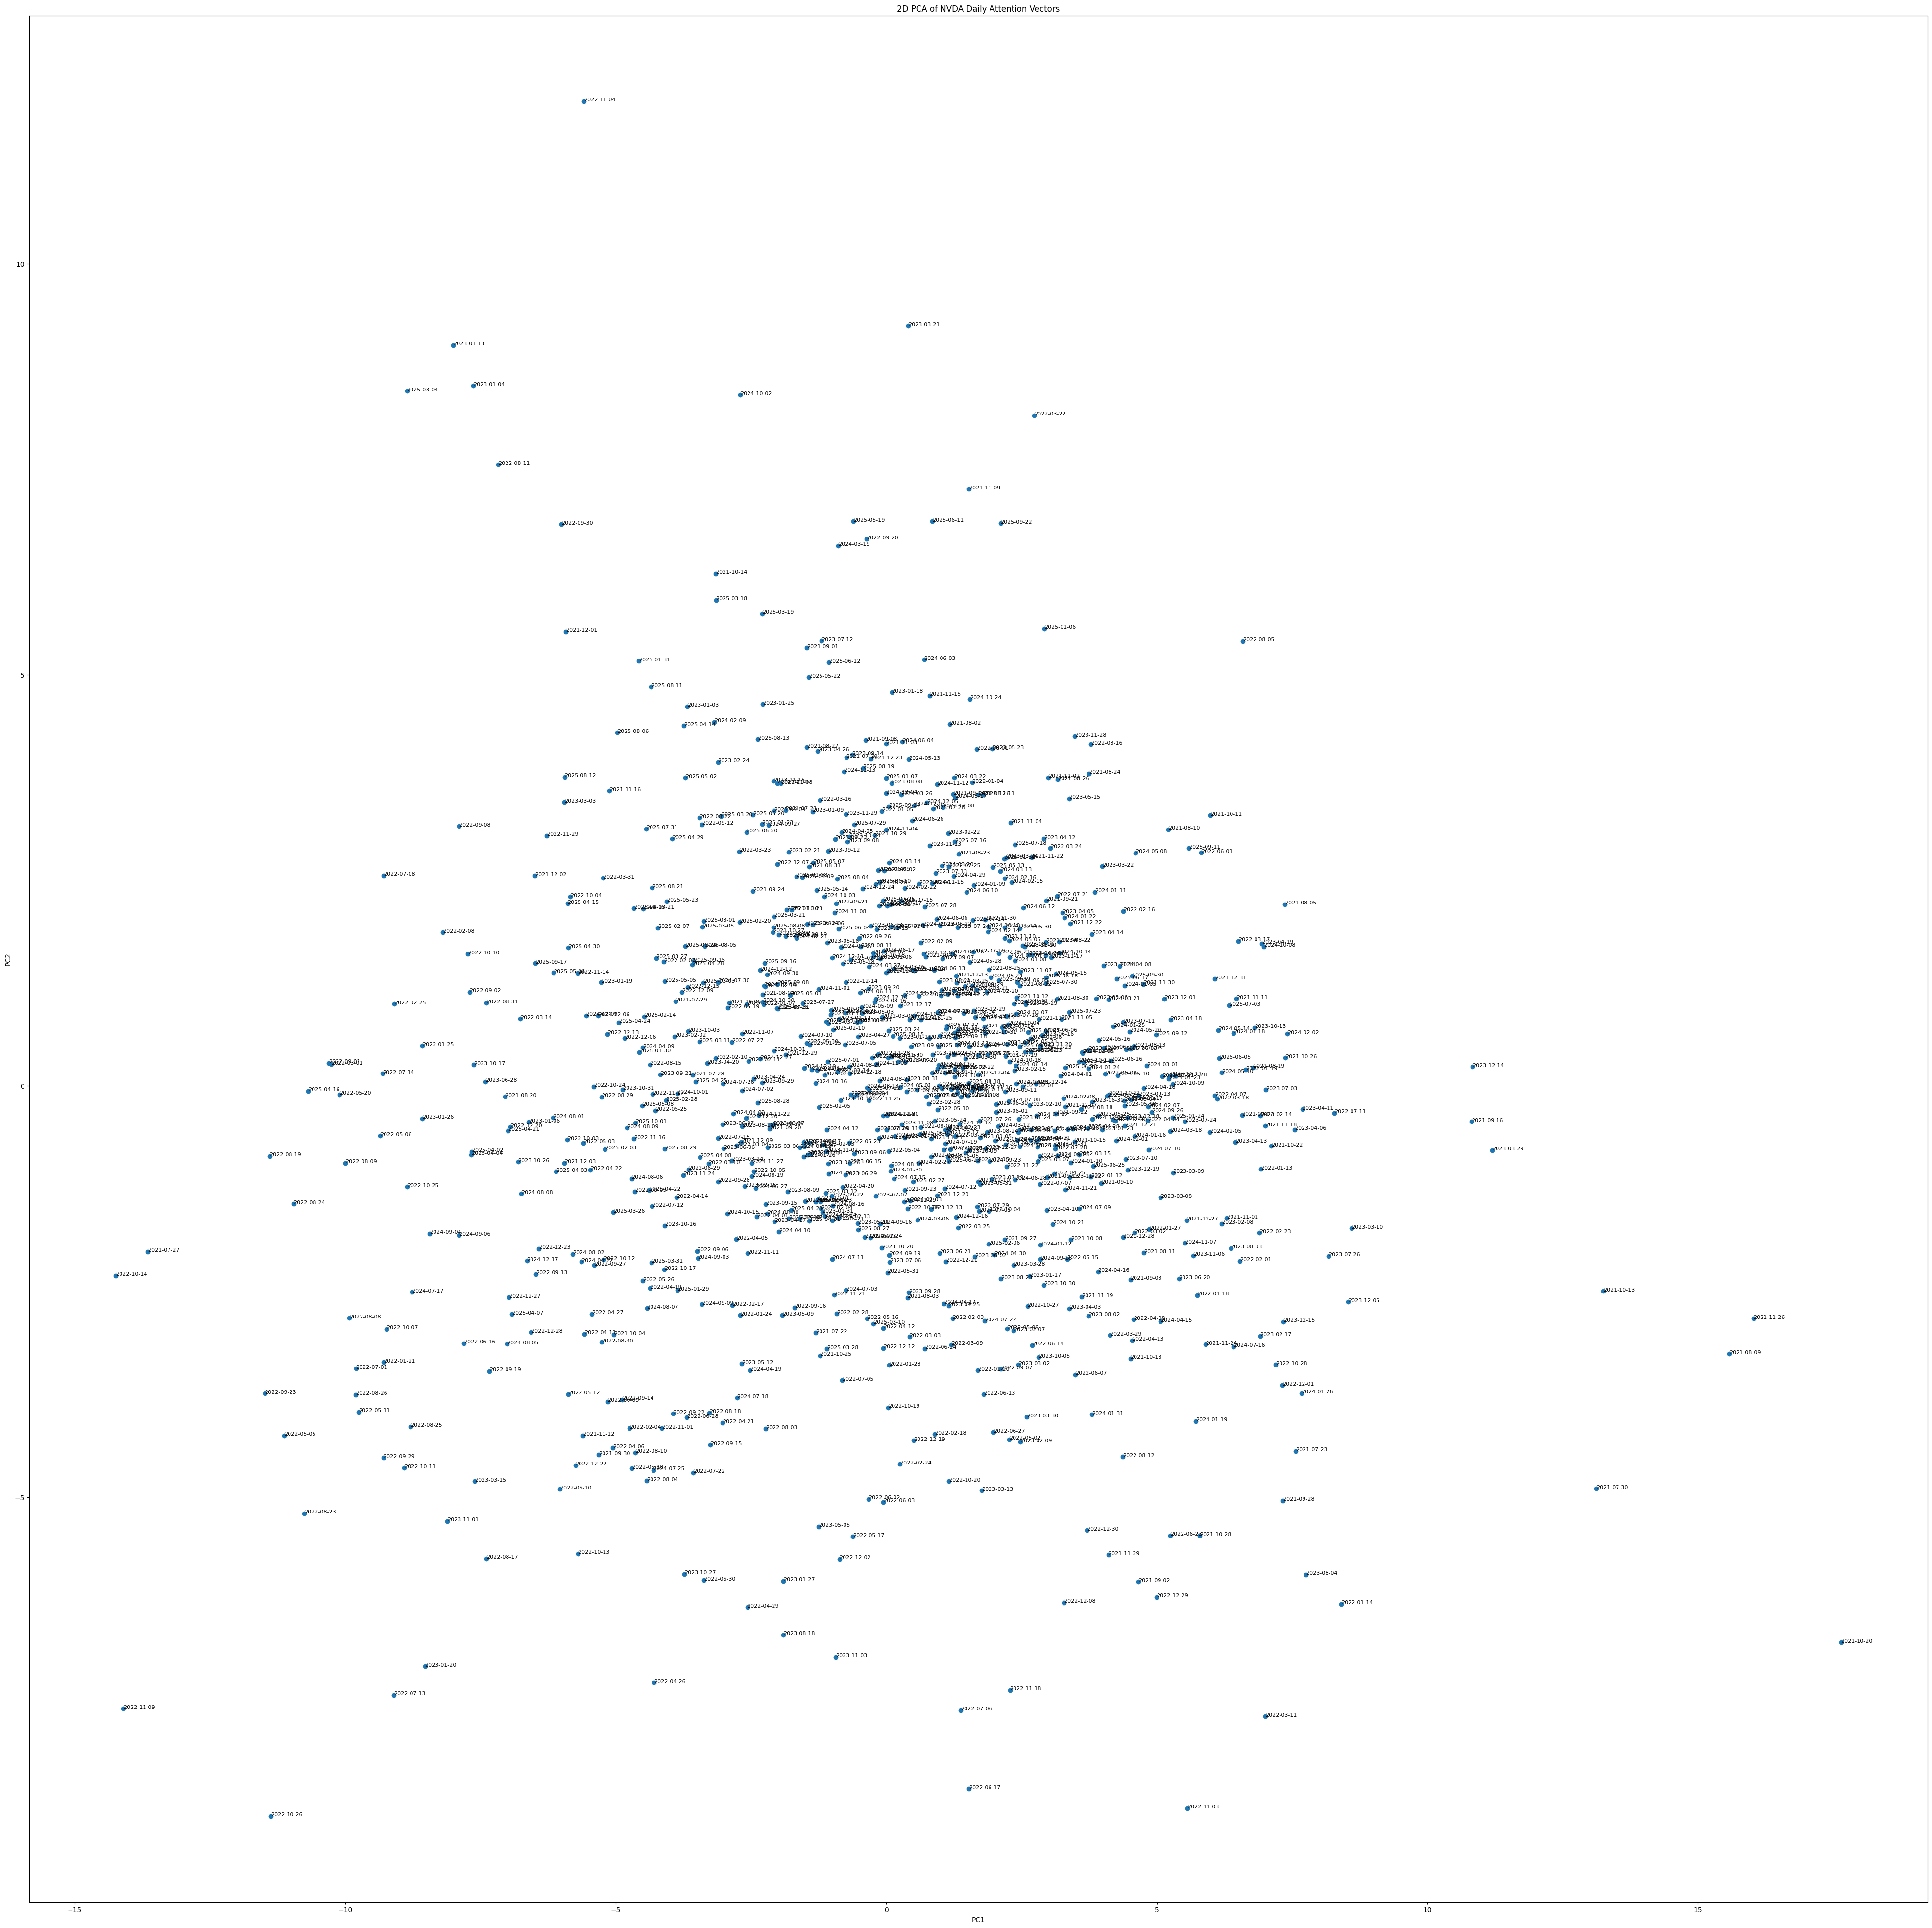

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dates = list(daily_attn_vectors.keys())
vectors = [daily_attn_vectors[date] for date in dates]

pca = PCA(n_components=2)
X_2d = pca.fit_transform(vectors)

plt.figure(figsize=(50,50))
plt.scatter(X_2d[:,0], X_2d[:,1])
for i, date in enumerate(dates):
    plt.annotate(date, (X_2d[i,0], X_2d[i,1]), fontsize=8)
plt.title("2D PCA of NVDA Daily Attention Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [13]:
day = '2021-11-26'
texts = df[df['date_only'] == day]['full_text'].tolist()
for i, t in enumerate(texts):
    print(f"Article {i+1}:\n{t}\n")


Article 1:
3 Innovative Stocks Shaping the Future of the Metaverse. The new virtual world presents unparalleled opportunities for humanity, and that's a major opportunity for these companies.

Article 2:
Nvidia Stock Is a Great Buy for Consistent, Long-Term Gains. Shares of chip and semiconductor designer Nvidia look unstoppable following the company's latest earnings beat. Nvidia stock has gained 18% since the Santa Clara, California-based company announced its third quarter results on November 17.



In [14]:
day = '2021-08-09'
texts = df[df['date_only'] == day]['full_text'].tolist()
for i, t in enumerate(texts):
    print(f"Article {i+1}:\n{t}\n")


Article 1:
Having Set Gaming Gold Standard, ‘Decade Stock' Nvidia Has Sights on AI. Nvidia has proved its strength in the gaming and AI industry time and again. The recent pullback in NVDA stock is an opportunity to buy.

Article 2:
After 5% Rise In A Week, What's Next For Nvidia Stock?. Nvidia stock has seen an impressive rise of 5% over the past week and currently trades at $206 per share. This rally was driven by expectations of strong earnings growth in the company's upcoming Q2 2022 results, expected later this month.



In [15]:
df

,Unnamed: 0,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers,parsed_date,parsed_date_local,date_only,time_only,full_text,embedding_finbert,sentiment_label_finbert,sentiment_score_finbert,mapped_trading_day
18,18,https://www.youtube.com/watch?v=8oyjWdcD5UE,https://cdn.snapi.dev/images/v1/r/l/j/ksnckw-2...,"Stock Market This Week: NVDA Record, INTC & AM...",Stocks rallied and all major indices hit new r...,Schwab Network,"Fri, 03 Oct 2025 19:00:08 -0400",[],Neutral,Video,"['AMD', 'INTC', 'NVDA', 'TSLA']",2025-10-03 23:00:08+00:00,2025-10-03 19:00:08-04:00,2025-10-03,19:00:08,"Stock Market This Week: NVDA Record, INTC & AM...","[-0.44401252, -0.34786892, 0.19721165, -0.2890...",Positive,0.997739,2025-10-03
19,19,https://www.investors.com/stock-lists/ibd-big-...,https://cdn.snapi.dev/images/v1/p/s/g/nvda8-26...,Magnificent Seven Member Nvidia Stock Breaks O...,"Nvidia, maker of the high-powered chips needed...",Investors Business Daily,"Fri, 03 Oct 2025 14:42:20 -0400",['paywall'],Positive,Article,['NVDA'],2025-10-03 18:42:20+00:00,2025-10-03 14:42:20-04:00,2025-10-03,14:42:20,Magnificent Seven Member Nvidia Stock Breaks O...,"[-0.031328592, -0.70110565, -0.09034682, -0.28...",Positive,0.999995,2025-10-03
20,20,https://www.youtube.com/watch?v=0YctcaOQyQE,https://cdn.snapi.dev/images/v1/q/g/q/semi2-33...,What to know about the international roadblock...,CNBC's Kristina Partsinevelos reports on the i...,CNBC Television,"Fri, 03 Oct 2025 12:25:02 -0400",[],Negative,Video,"['AMAT', 'NVDA']",2025-10-03 16:25:02+00:00,2025-10-03 12:25:02-04:00,2025-10-03,12:25:02,What to know about the international roadblock...,"[-0.48041955, -0.89286053, 0.005924, 0.2975579...",Neutral,0.999935,2025-10-03
21,21,https://www.barrons.com/articles/intel-nvidia-...,https://cdn.snapi.dev/images/v1/9/a/j/semi19-3...,"Intel, Nvidia, and the ‘Visible Hand' of Trump...",Adam Smith wrote about free-market incentives ...,Barrons,"Fri, 03 Oct 2025 12:02:00 -0400",['paywall'],Neutral,Article,"['INTC', 'NVDA']",2025-10-03 16:02:00+00:00,2025-10-03 12:02:00-04:00,2025-10-03,12:02:00,"Intel, Nvidia, and the ‘Visible Hand' of Trump...","[-0.48281595, -0.5145131, 0.113527, 0.2677936,...",Neutral,0.999964,2025-10-03
22,22,https://invezz.com/news/2025/10/03/why-nvidia-...,https://cdn.snapi.dev/images/v1/v/d/q/nvda24-2...,Why Nvidia stock is stuck on Friday,Nvidia stock gave up early gains on Friday as ...,Invezz,"Fri, 03 Oct 2025 11:58:00 -0400",[],Negative,Article,['NVDA'],2025-10-03 15:58:00+00:00,2025-10-03 11:58:00-04:00,2025-10-03,11:58:00,Why Nvidia stock is stuck on Friday. Nvidia st...,"[-0.1800308, -0.39486298, -0.23910274, 0.02179...",Negative,0.999806,2025-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19280,19280,https://seekingalpha.com/article/4437455-nvidi...,https://cdn.snapi.dev/images/v1/e/r/x/semi10-8...,"Is Nvidia A Good Dividend Stock? Yes, But Not Now",Nvidia Corp pays a paltry but growing dividend...,Seeking Alpha,"Thu, 01 Jul 2021 11:05:00 -0400","['dividend', 'paylimitwall']",Neutral,Article,['NVDA'],2021-07-01 15:05:00+00:00,2021-07-01 11:05:00-04:00,2021-07-01,11:05:00,"Is Nvidia A Good Dividend Stock? Yes, But Not ...","[-0.057309218, -0.5773786, -0.0032533973, -0.4...",Positive,1.000000,2021-07-19
19281,19281,https://www.marketwatch.com/story/nvidia-price...,https://cdn.snapi.dev/images/v1/h/i/x/semi7-89...,Nvidia price target raised to new Street high ...,BMO Capital Markets analyst Ambrish Srivastava...,Market Watch,"Thu, 01 Jul 2021 09:18:22 -0400",['paylimitwall'],Positive,Article,['NVDA'],2021-07-01 13:18:22+00:00,2021-07-01 09:18:22-04:00,2021-07-01,09:18:22,Nvidia price target raised to new Street high ...,"[0.07279291, -0.45469266, -0.10320045, -0.3581...",Positive,0.999977,2021-07-19
19282,19282,https://www.fool.com/investing/2021/07/01/is-n...,https://cdn.snapi.dev/images/v1/k/o/s/semi8-89...,Is NVIDIA Headed to $900? 3 Things to Know,The growth opportunities are 

In [16]:
# --------------------------------------------
# 6. Convert to DataFrame
# --------------------------------------------

daily_vectors_df = pd.DataFrame([
    {"date": date, "embedding": vec} for date, vec in daily_attn_vectors.items()
])

In [17]:
daily_vectors_df.to_csv(f"{ticker}_Daily_Vectors_full.csv")

In [ ]:
# df.drop(columns=['embedding_finbert']).to_csv(f"{ticker}_articles_finb_sentiment.csv")

In [ ]:
# daily_vectors_df

In [18]:
daily_vectors_df

,date,embedding
0,2025-10-03,"[-1.075272, -1.1914136, 0.35514158, 0.01089060..."
1,2025-10-02,"[-1.1027429, -1.1640657, 0.3463786, -0.063345,..."
2,2025-10-01,"[-1.2217209, -0.8748701, 0.58807665, 0.3424315..."
3,2025-09-30,"[-0.7244698, -1.2858515, 0.5443378, -0.1245898..."
4,2025-09-29,"[-1.0121285, -1.1659822, 0.5867567, -0.1374906..."
...,...,...
1001,2021-07-23,"[-0.47379965, -0.6802175, 0.6346405, -0.225708..."
1002,2021-07-22,"[-0.9779762, -0.6867899, 0.5805945, 0.18770638..."
1003,2021-07-21,"[-0.72345334, -0.9805167, 0.46579984, 0.250223..."
1004,2021-07-20,"[-0.6346245, -1.209862, 0.45194957, 0.09674487..."


In [20]:
trading_days_df_renamed = trading_days_df.rename(columns={'Date': 'date'})
merged_df = pd.merge(trading_days_df_renamed, daily_vectors_df, on='date', how='outer', indicator=True)
merged_df.head()


,Unnamed: 0,date,embedding,_merge
0,0,2021-07-19,"[-0.8172813, -1.1175796, 0.58274984, -0.008822...",both
1,1,2021-07-20,"[-0.6346245, -1.209862, 0.45194957, 0.09674487...",both
2,2,2021-07-21,"[-0.72345334, -0.9805167, 0.46579984, 0.250223...",both
3,3,2021-07-22,"[-0.9779762, -0.6867899, 0.5805945, 0.18770638...",both
4,4,2021-07-23,"[-0.47379965, -0.6802175, 0.6346405, -0.225708...",both


In [21]:
merged_df._merge.value_counts()

,count
_merge,
both,1006
left_only,53
right_only,0
